In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = (10.0, 7.0)
%config InlineBackend.figure_format = 'retina'

In [13]:
def cov_to_pts(cov):
    circ = np.linspace(0, 2 * np.pi, 500)
    sf = np.asarray([np.cos(circ), np.sin(circ)])
    [u, s, v] = np.linalg.svd(cov)
    pmat = u * 2.447 * np.sqrt(s) # 95% confidence
    return np.dot(pmat, sf)

def plot(means, sigmas):
    preds = C.dot(means.T)
    plt.scatter(*mat['data'].T, label='Observed Data')
    plt.plot(*mat['true_data'].T, label='True Position')
    plt.plot(*preds, label='Estimated Position')
    
    for i in range(sigmas.shape[0]):
        pts = cov_to_pts(C.dot(sigmas[i].dot(C.T)))
        pts += np.atleast_2d(preds.T[i]).T
        plt.plot(*pts, ls='-')
    
    plt.legend()
    plt.title('Estimated vs. True Points')

In [14]:
def calc_sigma_prime(sigma):
    return A.dot(sigma.dot(A.T)) + Q

def calc_s_t(sigma_prime):
    return C.dot(sigma_prime.dot(C.T)) + R

def calc_kalman_gain(sigma):
    sigma_prime = calc_sigma_prime(sigma)
    s_t_inv = np.linalg.pinv(calc_s_t(sigma_prime))
    return sigma_prime.dot(C.T.dot(s_t_inv))

def calc_predictions(prev_means):
    return C.dot(A.dot(prev_means))

In [15]:
def calc_sigma(prev):
    sigma_prime = calc_sigma_prime(prev)
    gain = calc_kalman_gain(prev)
    iden = np.identity(len(prev))
    return np.dot(iden - gain.dot(C), sigma_prime)

def calc_means(prev, sigma, observations):
    gain = calc_kalman_gain(sigma)
    pred = calc_predictions(prev)
    return A.dot(prev) + gain.dot(np.atleast_2d(observations).T - pred)

## Dataset 1

In [16]:
mat = loadmat('kfdata.mat')

In [17]:
data = mat['data']

In [18]:
# our dynamics are described by random accelerations
A = np.asarray([
    [ 1, 0, 1, 0, 0.5, 0 ],
    [ 0, 1, 0, 1, 0, 0.5 ],
    [ 0, 0, 1, 0, 1, 0 ],
    [ 0, 0, 0, 1, 0, 1 ],
    [ 0, 0, 0, 0, 1, 0 ],
    [ 0, 0, 0, 0, 0, 1 ]])
 
# our observations are only the position components
C = np.asarray([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0]])
 
# our dynamics noise tries to force random accelerations to account
# for most of the dynamics uncertainty
Q = 1e-2 * np.eye( 6 )
Q[4,4] = 0.5  # variance of accelerations is higher
Q[5,5] = 0.5
 
# our observation noise
R = 20 * np.eye( 2 )
 
# initial state
mu_t = np.zeros(( 6, 1 ))
sigma_t = np.eye( 6 )

In [19]:
means = [mu_t]
sigmas = [sigma_t]
for i in range(data.shape[0]):
    means.append(calc_means(means[-1], sigmas[-1], data[i]))
    sigmas.append(calc_sigma(sigmas[-1]))
means = np.array(means).squeeze()
sigmas = np.array(sigmas).squeeze()

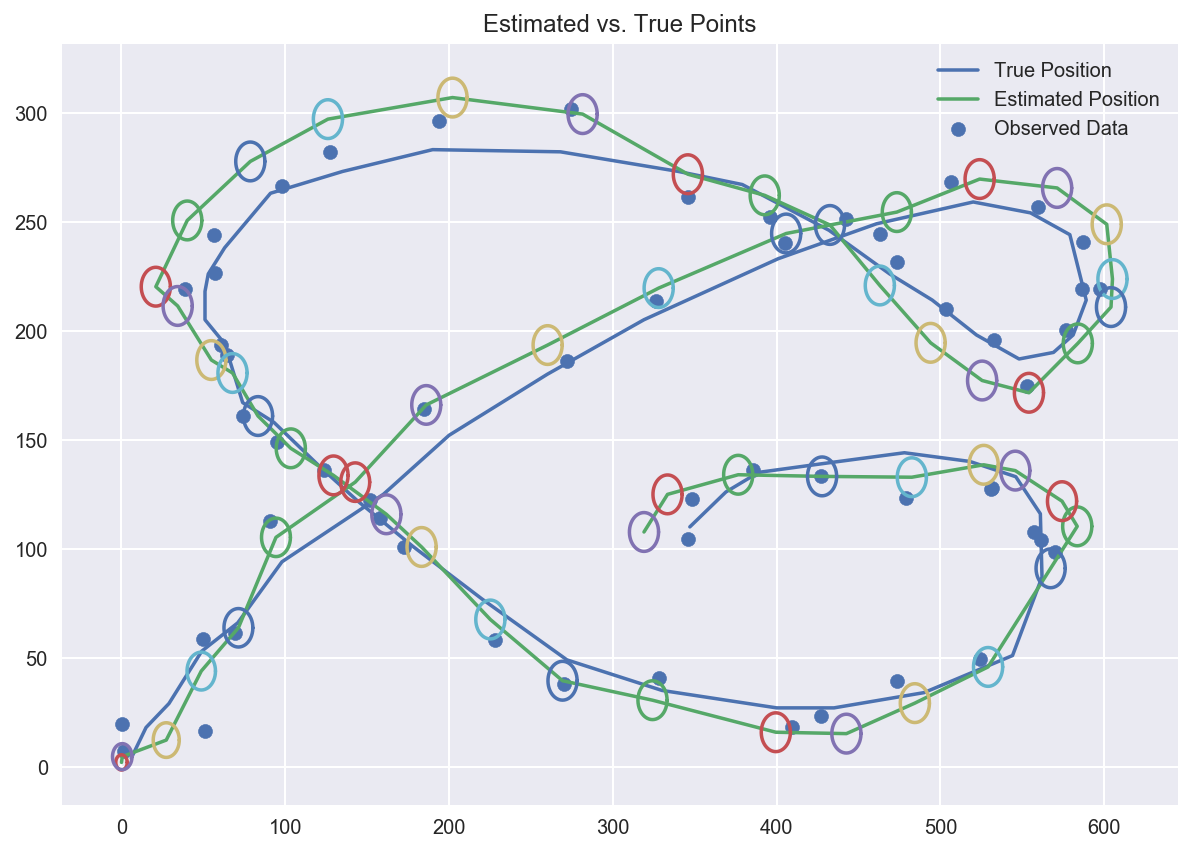

In [20]:
plot(means[1:], sigmas[1:])

## Dataset 2

In [21]:
import skimage.feature

tmp = loadmat('ball_data.mat')
frames = tmp['frames']  # frames of our video
ball = tmp['ball']  # our little template
 
data = []
for i in range( 0, frames.shape[1] ):
    tmp = np.reshape( frames[:,i], (360,243) ).T  # slurp out a frame
    ncc = skimage.feature.match_template( tmp, ball )  # create a normalized cross correlation image
    maxloc = np.unravel_index( tmp.argmax(), tmp.shape )  # find the point of highest correlation
    data.append( maxloc )  # record the results

data = np.asarray( data )

### Parameter Selection
Our $A$ matrix allows us to use velocity, acceleration, and position to calculate a position after $t=1$ by the following equation:

$$x_2 = x_1 + vt + \dfrac{1}{2}at^2 = x_1 + v + \dfrac{1}{2}a$$

For the parameters, I began with a "position" where the ball occurs in the first frames. The label does not appear there, but I thought that it would be best to begin where the ball actually appears like the example on the spec does. Since we are very confident of the original position since we found it by inspection, I opted for a small initial covariance, which does allow it to be truer to the actual position of the ball in the beginning where the labels are unclear.

The other parameters I adjusted were $Q$ and $R$. I went with a very small $Q$ in order to create a smoother-rolling ball, with by far the greatest weight on the accelerations, as seen below. This allows for a relatively smooth prediction while maintaining pretty good accuracy. Since there is a lot of variation between frames, and between the labels and the actual data, I made $R$ quite large so that each predicted point would have a fairly large variance to capture the truth with greater likelihood.

In [22]:
mu_t[0] = 150
mu_t[1] = 350
sigma_t = .1 * np.eye( 6 )

Q = .00001 * np.eye( 6 )
Q[4,4] = .0005
Q[5,5] = .0005

R = 2000 * np.eye( 2 )

In [23]:
means = [mu_t]
sigmas = [sigma_t]
for i in range(data.shape[0]):
    means.append(calc_means(means[-1], sigmas[-1], data[i]))
    sigmas.append(calc_sigma(sigmas[-1]))
means = np.array(means).squeeze()
sigmas = np.array(sigmas).squeeze()

In [24]:
mus = C.dot(means[1:].T).T
covs = C.dot(sigmas[1:].dot(C.T)).transpose((1,0,2))

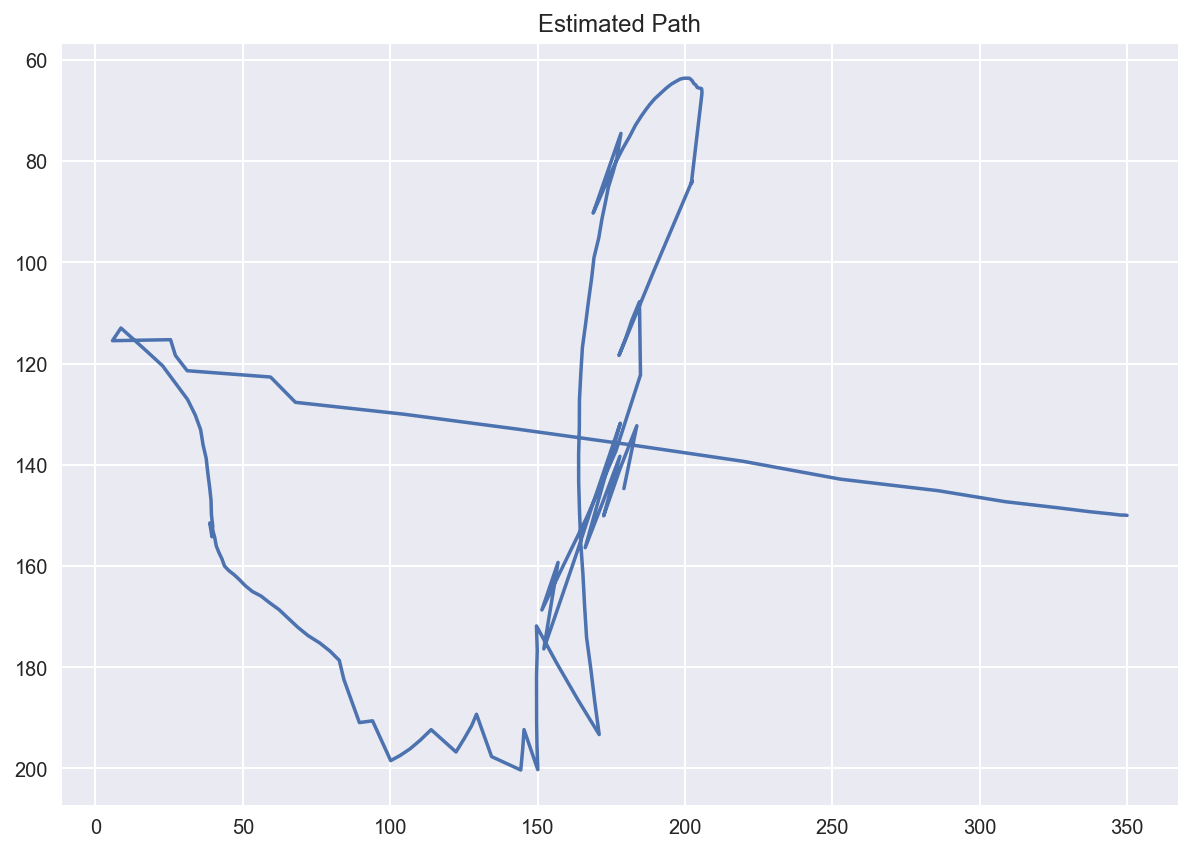

In [25]:
plt.plot(mus[:,1], mus[:,0])
plt.gca().invert_yaxis()
plt.title('Estimated Path')
plt.show()

In [26]:
def img_num(i, sb):
    plt.subplot(sb)
    tmp = np.reshape( frames[:,i], (360,243) ).T
    
    plt.imshow( tmp, interpolation='nearest', cmap='gray' )
    plt.scatter( data[i][1], data[i][0] )
    plt.scatter( mus[i][1], mus[i][0] )

    foo = cov_to_pts( covs[i][0:2,0:2] )
    plt.plot([])
    plt.plot( foo[0,: ] + mus[i][1], foo[1,:] + mus[i][0] )
    plt.xlim([1, 360])
    plt.ylim([243,1])
    plt.title('Frame {}'.format(i))

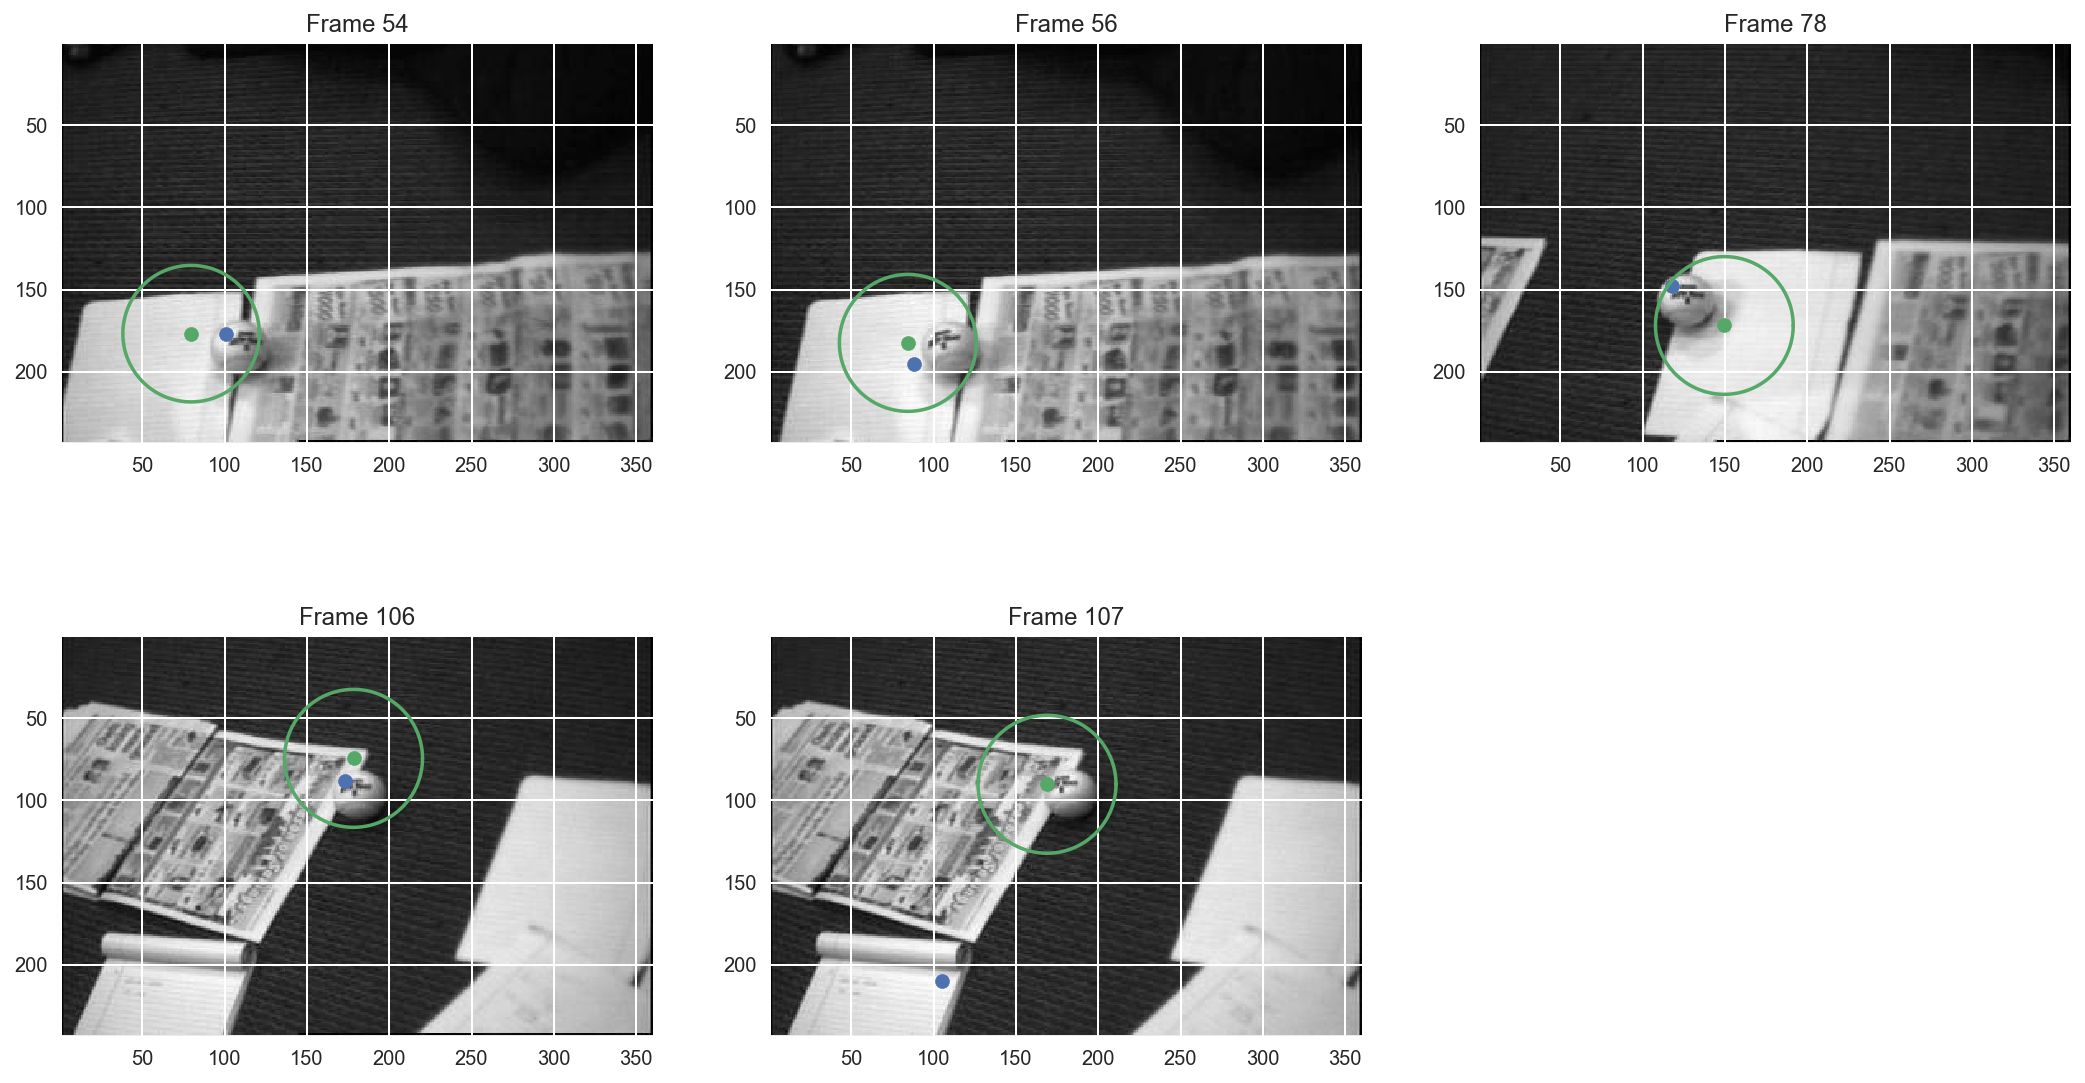

In [27]:
plt.figure(1, figsize=(18, 10))
img_num(54, 231)
img_num(56, 232)
img_num(78, 233)
img_num(106, 234)
img_num(107, 235)
sns.axes_style('ticks')
plt.show()

In [ ]:
from IPython.display import clear_output
 
for t in range(0, data.shape[0]):
 
    tmp = np.reshape( frames[:,t], (360,243) ).T
 
    plt.figure(1)
    plt.clf()
    plt.imshow( tmp, interpolation='nearest', cmap='gray' )
    plt.scatter( data[t][1], data[t][0] )
    plt.scatter( mus[t][1], mus[t][0] )

    foo = cov_to_pts( covs[t][0:2,0:2] )

    plt.plot([])
    plt.plot( foo[0,: ] + mus[t][1], foo[1,:] + mus[t][0] )
    plt.xlim([1, 360])
    plt.ylim([243,1])
    clear_output(wait = True)
 
    plt.pause(0.0001)